# TensorFlow

참고 : TensorFlow Machine Learning Cookbook

In [1]:
import tensorflow as tf
sess = tf.Session()

C:\Users\GIGABYTE\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np
import matplotlib.pyplot as plt

### 텐서플로의 커널 함수
> 비선형 데이터를 구분하고자 한다면 데이터에 선형 구분자를 투사하는 방법을 바꿔야 한다.
> SVM 비용 함수 커널을 변경하면 된다.

> ##### Linear Kernel: K(x1, x2) = t(x1) * x2
> ##### Gaussian Kernel (RBF): K(x1, x2) = exp(-gamma * abs(x1 - x2)^2)

In [3]:
# 데이터 로드
from sklearn import datasets
(x_vals, y_vals) = datasets.make_circles(n_samples=350, factor=0.5, noise=0.1)

y_vals = np.array([1 if y==1 else -1 for y in y_vals])
class1_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i, x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i, x in enumerate(x_vals) if y_vals[i]==-1]


# 일괄 작업 크기 선언
# - SVM에서는 학습 단계마다 출렁거리지 않을 안정적인 모델을 원하기 때문에 알괄 작업 크기를 크게하는 경향이 있다.
batch_size = 350


# 플레이스홀더 및 변수 선언
x_data = tf.placeholder(shape=[None,2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None,2], dtype=tf.float32)
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))


# 가우시안 커널 생성
gamma = tf.constant(-50.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

# Linear
# my_kernel = tf.matmul(x_data, tf.transpose(x_data))


# 이중 최적화 문제 선언
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))


# 예측 커널 생성
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1), [-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), 
                      tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

# Linear
# pred_kernel = tf.matmul(x_data, tf.transpose(prediction_grid))

prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target), b), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))


# 최적화 함수 생성
my_opt = tf.train.GradientDescentOptimizer(0.002)
train_step = my_opt.minimize(loss)


# 변수 초기화
init = tf.global_variables_initializer()
sess.run(init)


# 학습
loss_vec = []
batch_acc = []

for i in range(1000):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data:rand_x, y_target:rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data:rand_x, y_target:rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data:rand_x, y_target:rand_y, prediction_grid:rand_x})
    batch_acc.append(acc_temp)
    
    if (i+1) % 250 == 0:
        print('Step #{}'.format(str(i+1)))
        print('Loss = {}\n'.format(str(temp_loss)))

Step #250
Loss = 42.902096

Step #500
Loss = -6.3217106

Step #750
Loss = -11.30212

Step #1000
Loss = -12.009345



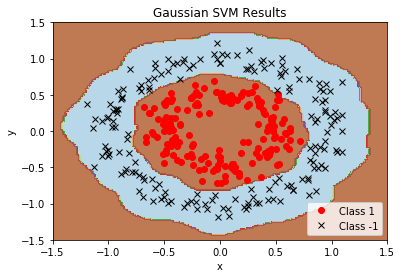

In [4]:
x_min, x_max = x_vals[:,0].min() - 1, x_vals[:,0].max() + 1
y_min, y_max = x_vals[:,1].min() - 1, x_vals[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data:rand_x, 
                                                     y_target:rand_y, 
                                                     prediction_grid:grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)


plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='Class 1')
plt.plot(class2_x, class2_y, 'kx', label='Class -1')
plt.title('Gaussian SVM Results')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.ylim([-1.5, 1.5])
plt.xlim([-1.5, 1.5])
plt.show()

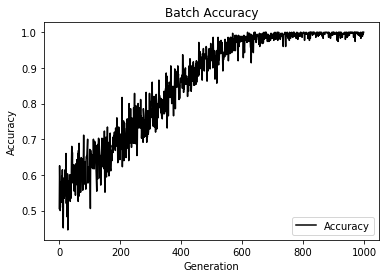

In [5]:
plt.plot(batch_acc, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

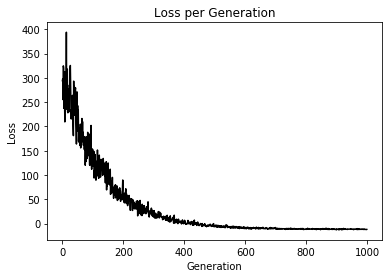

In [6]:
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

> 가우시안 커널에는 또 하나의 매개변수 gamma가 있다. 
> gamma는 데이터 지점이 구분 곡선에 미치는 영향도를 제어한다. 
> 보통은 작은 값을 사용하지만, 데이터셋에 따라 적절한 값을 선택해야 한다. 
> 교차 검증 등의 통계 기법을 통해 이 매개변수 값을 정하는 것이 이상적이다.